**Цель нашего исследования - создать две  модели, чтобы помочь фермеру кпить новых коровсогласно его требований:**
 - Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
 - Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

**ПЛАН РАБОТЫ**
- Предобработка данных 

- Исследовательский анализ данных 
- Корреляционный анализ данных
- Обучение модели линейной регрессии 

Сделать итоговые выводы

In [1]:
!pip install -U scikit-learn
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt
import seaborn as sns
pd.set_option('display.float_format', '{:,.2f}'.format)
import scipy.stats as st
from scipy.stats import binom, norm

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pylab
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


## Загрузка данных

In [2]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';')

In [3]:
def dataset(data):
   
    print(data.info())
    print()
    print('Количество пропусков:')
    print(data.isna().sum())
    print()
    print('Количество дубликатов:')
    print(data.duplicated().sum())
    print()
    return data.head(5) 
    

In [4]:
dataset(ferma_main)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


**Описание данных**
 - **id** — уникальный идентификатор коровы.
 - **Удой, кг** — масса молока, которую корова даёт в год (в килограммах).
 - **ЭКЕ (Энергетическая кормовая единица)** — показатель питательности корма коровы.
 - **Сырой протеин, г** — содержание сырого протеина в корме (в граммах).
 - **СПО (Сахаро-протеиновое соотношение)** — отношение сахара к протеину в корме коровы.
 - **Порода** — порода коровы.
 - **Тип пастбища** — ландшафт лугов, на которых паслась корова.
 - **порода папы_быка** — порода папы коровы.
 - **Жирность,%** — содержание жиров в молоке (в процентах).
 - **Белок,%** — содержание белков в молоке (в процентах).
 - **Вкус молока** — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
 - **Возраст** — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Предварительный вывод:**
 - В датасете нет пропущенных значений
 - Есть 5 явных дубликатов. Удалим их
 - Столбецы **ЭКЕ (Энергетическая кормовая единица)** , **СПО (Сахаро-протеиновое соотношение)** , **Жирность,%** и **Белок,%** имеют тип данных  **object** . Необходимо заменить его на **float**
 - Так же мы видим длинные названия столбцов. Скоратим их

In [5]:
dataset(ferma_dad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None

Количество пропусков:
id          0
Имя Папы    0
dtype: int64

Количество дубликатов:
0



,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


**Описание данных:**
 - **id** — уникальный идентификатор коровы.
 - **Имя Папы** — имя папы коровы.

Дубликатов нет, пропущенных значений нет. предобработка не требуется


In [6]:
dataset(cow_buy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB
None

Количество пропусков:
Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

Количество дубликатов:
4



,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


**Описание данных:**
 - **Порода** — порода коровы.
 - **Тип пастбища** — ландшафт лугов, на которых паслась корова.
 - **порода папы_быка** — порода папы коровы.
 - **Имя_папы** — имя папы коровы.
 - **Текущая_жирность,%** — содержание жиров в молоке (в процентах).
 - **Текущий_уровень_белок,%** — содержание белков в молоке (в процентах).
 - **Возраст** — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Предварительный вывод:**
 - Пропусков нет
 - В датасете 4 явных дубликата.
 - Столбцы **Текущая_жирность,%** и **Текущий_уровень_белок,%** имеют тип данных **object**. Заменим его на  **float**

##  Предобработка данных

Сократим названия столбцов, притведем их к нижнему регисту, проверим уникальные значения и при необходимости обработаем

In [7]:
#скоращаем названия столбцов и выводим первый 5 строк датафрейма
ferma_main.rename(columns = {'ЭКЕ (Энергетическая кормовая единица)':'ЭКЕ', 'СПО (Сахаро-протеиновое соотношение)':'СПО'}, inplace = True )
for i in ['ЭКЕ', 'СПО', 'Жирность,%', 'Белок,%']:
    ferma_main[i] = ferma_main[i].str.replace(',','.')
ferma_main.head()    

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.4,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [8]:
#Приведем все  к нижнему регистру и удалим лишние символы
cols = ['порода папы_быка','Порода', 'Тип пастбища','Возраст']
for i in cols:
    ferma_main[i] = ferma_main[i].str.lower()
    ferma_main[i] = ferma_main[i].str.replace('_', '')
    ferma_main[i] = ferma_main[i].str.replace('"', '')
    ferma_main[i] = ferma_main[i].str.replace(' - ', '-')
    ferma_main[i] = ferma_main[i].str.replace(' ', '')
    ferma_main[i] = ferma_main[i].str.strip()



В столбце **Тип пастбища** есть однинковые названия с разным написанием. Исправим:

In [9]:
ferma_main['ЭКЕ'] = ferma_main['ЭКЕ'].astype(float)
ferma_main['СПО'] = ferma_main['СПО'].astype(float)
ferma_main['Жирность,%'] = ferma_main['Жирность,%'].astype(float)
ferma_main['Белок,%'] = ferma_main['Белок,%'].astype(float)
ferma_main.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.20,1743,0.89,висбикайдиал,равнинное,айдиал,3.58,3.08,вкусно,более2лет
1,2,5529,12.80,2138,0.89,висбикайдиал,равнинные,соверин,3.54,3.08,вкусно,менее2лет
2,3,5810,14.00,1854,0.89,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более2лет
3,4,5895,12.40,2012,0.89,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более2лет
4,5,5302,12.80,1675,0.89,висбикайдиал,равнинные,соверин,3.73,3.07,вкусно,менее2лет


In [10]:
#Выводим уникальные значения для столбцов "Порода", "Тип пастбища"  и "порода папы_быка"
print(ferma_main['Порода'].unique())
print(ferma_main['порода папы_быка'].unique())

ferma_main['Тип пастбища'].unique()

['висбикайдиал' 'рефлешнсоверинг']
['айдиал' 'соверин' 'айдиалл']


array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

В столбцах есть одинаковые названия с разным написанием . Исправим

In [11]:
ferma_main['порода папы_быка'] = ferma_main['порода папы_быка'].str.replace('айдиалл','айдиал')
print(ferma_main['порода папы_быка'].unique())
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].str.replace('равнинные','холмистое')
ferma_main['Тип пастбища'].unique()

['айдиал' 'соверин']


array(['равнинное', 'холмистое'], dtype=object)

In [12]:
#удалим явные дубликаты и проверим датасет после удаления
ferma_main = ferma_main.drop_duplicates().reset_index(drop = True)
ferma_main.duplicated().sum()

0

In [13]:
#выведем уникальные значения для столбцов "вкус молока" и "возраст"
print(ferma_main['Вкус молока'].unique())

ferma_main['Возраст'].unique()

['вкусно' 'не вкусно']


array(['более2лет', 'менее2лет'], dtype=object)

Дубликатов не обнаружено. Обработка не требуется

ранее мы увидели , что тип данных в столбцах не соответствует .Исправим это:

In [14]:
ferma_main['ЭКЕ'] = ferma_main['ЭКЕ'].astype(float)
ferma_main['СПО'] = ferma_main['СПО'].astype(float)
ferma_main['Жирность,%'] = ferma_main['Жирность,%'].astype(float)
ferma_main['Белок,%'] = ferma_main['Белок,%'].astype(float)
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   Удой, кг          629 non-null    int64  
 2   ЭКЕ               629 non-null    float64
 3   Сырой протеин, г  629 non-null    int64  
 4   СПО               629 non-null    float64
 5   Порода            629 non-null    object 
 6   Тип пастбища      629 non-null    object 
 7   порода папы_быка  629 non-null    object 
 8   Жирность,%        629 non-null    float64
 9   Белок,%           629 non-null    float64
 10  Вкус молока       629 non-null    object 
 11  Возраст           629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB


In [15]:
#удалим явные дубликаты
ferma_main = ferma_main.drop_duplicates().reset_index(drop = True)
ferma_main.duplicated().sum()

0

**ferma_dad**

In [16]:

cols = ['Имя Папы']
for i in cols:
    ferma_dad[i] = ferma_dad[i].str.lower()
    ferma_dad[i] = ferma_dad[i].str.replace('_', '')
    ferma_dad[i] = ferma_dad[i].str.replace('"', '')
    ferma_dad[i] = ferma_dad[i].str.replace(' - ', '-')
    ferma_dad[i] = ferma_dad[i].str.replace(' ', '')
    ferma_dad[i] = ferma_dad[i].str.strip()

Сделаем предобрабтку данных в датасете **cow_buy**

In [17]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.20,1743,0.89,висбикайдиал,равнинное,айдиал,3.58,3.08,вкусно,более2лет
1,2,5529,12.80,2138,0.89,висбикайдиал,холмистое,соверин,3.54,3.08,вкусно,менее2лет
2,3,5810,14.00,1854,0.89,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более2лет
3,4,5895,12.40,2012,0.89,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более2лет
4,5,5302,12.80,1675,0.89,висбикайдиал,холмистое,соверин,3.73,3.07,вкусно,менее2лет


In [18]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [19]:
#приведем все к нижнему регисистру и удалим спец.символы
cols = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы', 'Возраст']
for i in cols:
    cow_buy[i] = cow_buy[i].str.lower()
    cow_buy[i] = cow_buy[i].str.replace('_', '')
    cow_buy[i] = cow_buy[i].str.replace('"', '')
    cow_buy[i] = cow_buy[i].str.replace(' - ', '-')
    cow_buy[i] = cow_buy[i].str.replace(' ', '')
    cow_buy[i] = cow_buy[i].str.strip()

In [20]:
#меням тип данных в столбцах
cow_buy.rename(columns = {'Текущий_уровень_белок,%':'Белок,%','Имя_папы':'Имя Папы','Текущая_жирность,%':'Жирность,%' }, inplace = True )
for i in ['Белок,%', 'Жирность,%']:
    cow_buy[i] = cow_buy[i].str.replace(',','.')
    cow_buy[i] = cow_buy[i].astype(float)
cow_buy.head()    

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.08,менее2лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более2лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более2лет


проверим уникальный категориальные значения

In [21]:
print(cow_buy['Порода'].unique())
print(cow_buy['Тип пастбища'].unique())
print(cow_buy['порода папы_быка'].unique())
print(cow_buy['Имя Папы'].unique())
cow_buy['Возраст'].unique()

['висбикайдиал' 'рефлешнсоверинг']
['холмистое' 'равнинное']
['айдиал' 'соверин']
['геркулес' 'буйный' 'барин' 'соловчик']


array(['более2лет', 'менее2лет'], dtype=object)

уникальные значения совпадают со значениями в первом датасете. обработка не требуется

In [22]:
#приведем все к нижнему регисистру и удалим спец.символы
cols = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя Папы', 'Возраст']
for i in cols:
    cow_buy[i] = cow_buy[i].str.lower()
    cow_buy[i] = cow_buy[i].str.replace('_', '')
    cow_buy[i] = cow_buy[i].str.replace('"', '')
    cow_buy[i] = cow_buy[i].str.replace(' - ', '-')
    cow_buy[i] = cow_buy[i].str.replace(' ', '')
    cow_buy[i] = cow_buy[i].str.strip()

**Предварительные выводы**
 - Выполнили предобработку данных
 - скоратили названия столбцов
 - Привели все  к нижнему регистру и удалили лишние символы
 - Привели в порядок  уникальные категориальные значения 
 - Удалили явные дубликаты в двух датафреймах

## Исследовательский анализ данных

In [23]:
#Выведем описание всех числовых значений датаырейма ferma_main

ferma_main.describe()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,"Жирность,%","Белок,%"
count,629.00,629.00,629.00,629.00,629.00,629.00,629.00
mean,315.00,"6,188.75",14.54,"1,923.36",0.91,3.60,3.08
std,181.72,"1,644.80",1.31,182.96,0.03,0.17,0.00
min,1.00,"5,204.00",10.90,"1,660.00",0.84,2.99,3.07
25%,158.00,"5,751.00",13.50,"1,771.00",0.89,3.59,3.07
50%,315.00,"6,133.00",14.70,"1,888.00",0.93,3.65,3.08
75%,472.00,"6,501.00",15.60,"2,062.00",0.94,3.72,3.08
max,629.00,"45,616.00",16.80,"2,349.00",0.96,3.75,3.08


Мы видим, что в столбце удой есть явный выброс в максимольном значение - 45616 кг

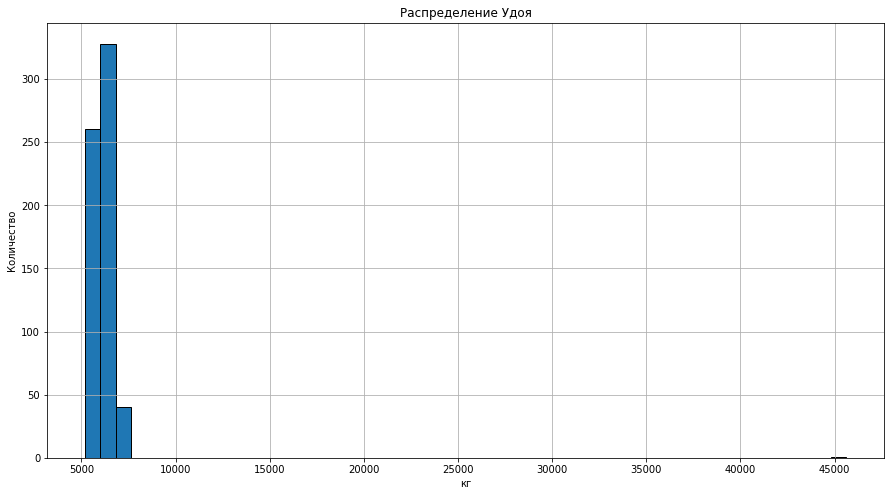

In [24]:
#Построим гистограмму
plt.figure(figsize=(15,8))
ferma_main['Удой, кг'].hist(bins=50,ec='black')
plt.title('Распределение Удоя')
plt.xlabel('кг')
plt.ylabel('Количество')
plt.show()

Из анализа мы видим, что в основном удой находится в диапазоне от 5751 до 6501. Есть выброс 45616 кг

In [25]:
#Удалим выброс в датафрейме
ferma_main = ferma_main[ferma_main['Удой, кг'] < 45000]

После удаления выбросов и постороения новой гистограммы можно сделать вывод, что распределение удоя теперь нормальное

array([[<AxesSubplot:title={'center':'Удой, кг'}>,
        <AxesSubplot:title={'center':'ЭКЕ'}>],
       [<AxesSubplot:title={'center':'Сырой протеин, г'}>,
        <AxesSubplot:title={'center':'СПО'}>],
       [<AxesSubplot:title={'center':'Жирность,%'}>,
        <AxesSubplot:title={'center':'Белок,%'}>]], dtype=object)

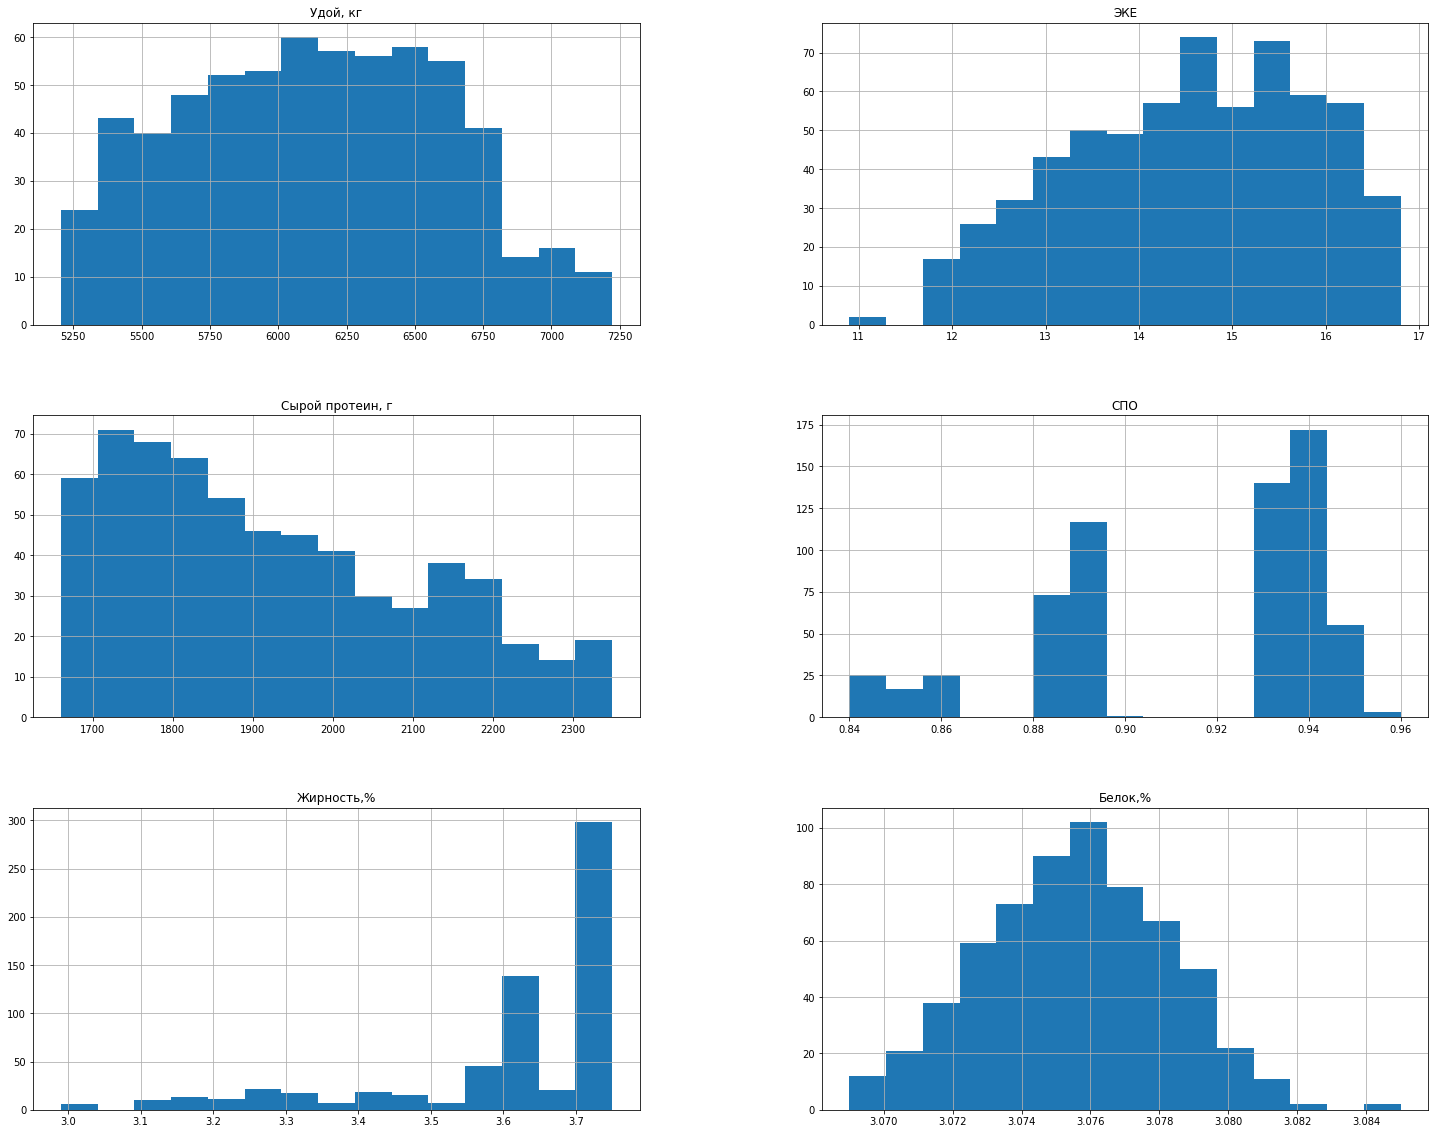

In [26]:
#Построим все гистограммы количественных признаков
ferma_main[['Удой, кг', 'ЭКЕ', 'Сырой протеин, г', 'СПО', 'Жирность,%', 'Белок,%']].hist(bins=15,figsize=(25, 20))

**Предварительные выводы:**
 - ЭКЕ распределено не нормально

 - Протеин распределен не нормально с скосом вправо

 - СПО распределено не нормально. можно выделить три группы 0.84-0.86, 0.88-0.89 и 0.93-0.95

 - Жирность распределена ненормально. Имеется два пика около 3.6% и 3.7%

 - Белок рапределен не нормально.

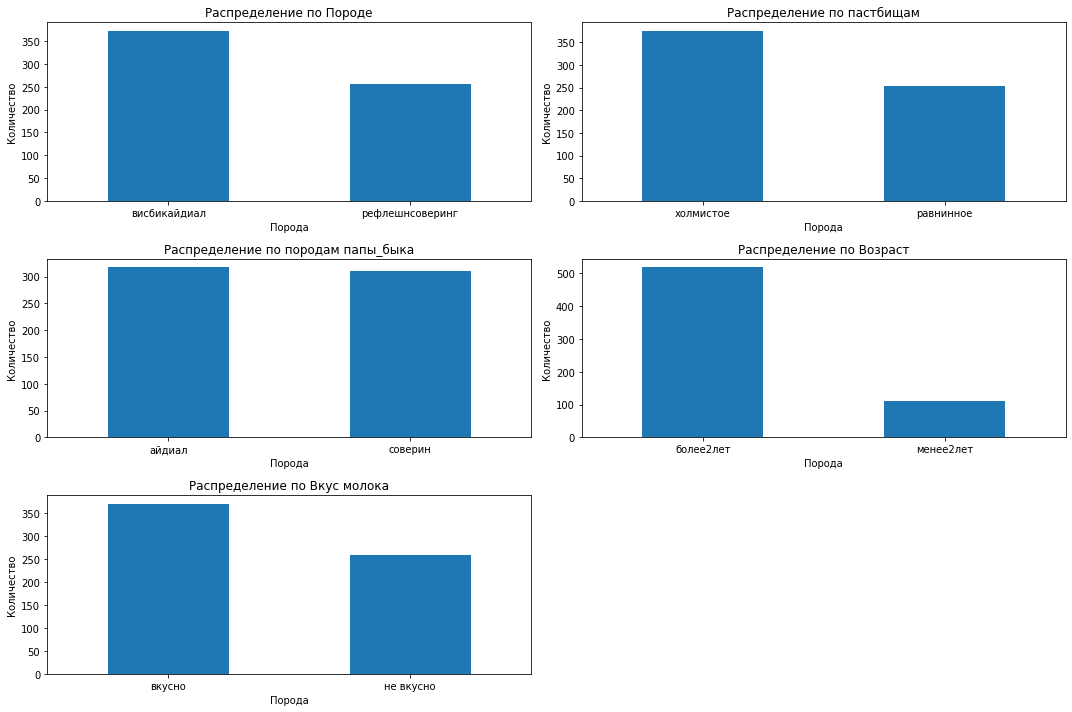

In [27]:

plt.subplot(3, 2, 1)
ax = ferma_main['Порода'].value_counts().plot.bar(figsize=(15,10),rot=0)
plt.title('Распределение по Породе')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.subplot(3, 2, 2)
ax = ferma_main['Тип пастбища'].value_counts().plot.bar(figsize=(15,10),rot=0)
plt.title('Распределение по пастбищам')
plt.xlabel('Порода')
plt.ylabel('Количество')

plt.subplot(3, 2, 3)
ax = ferma_main['порода папы_быка'].value_counts().plot.bar(figsize=(15,10),rot=0)
plt.title('Распределение по породам папы_быка')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.subplot(3, 2, 4)
ax = ferma_main['Возраст'].value_counts().plot.bar(figsize=(15,10),rot=0)
plt.title('Распределение по Возраст')
plt.xlabel('Порода')
plt.ylabel('Количество')

plt.subplot(3, 2, 5)
ax = ferma_main['Вкус молока'].value_counts().plot.bar(figsize=(15,10),rot=0)
plt.title('Распределение по Вкус молока')
plt.xlabel('Порода')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()





## Корреляционный анализ

<AxesSubplot:>

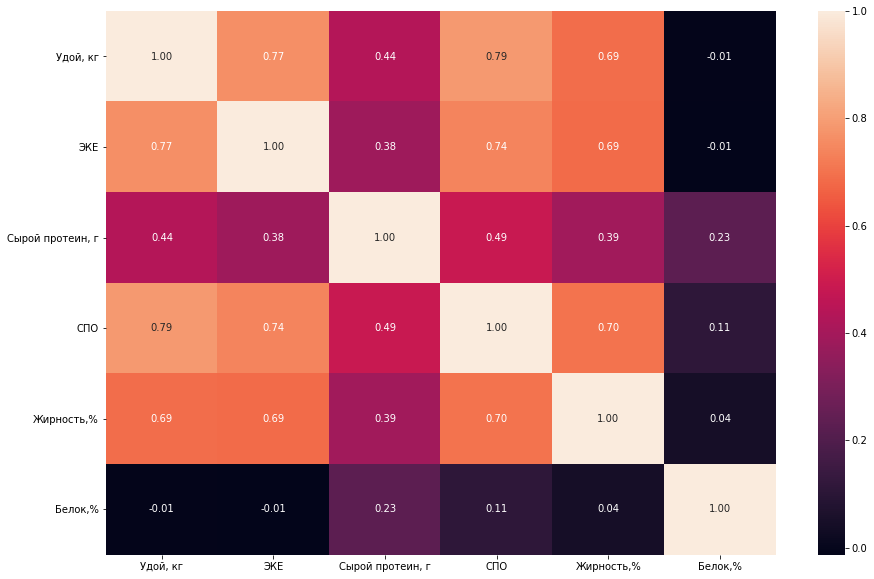

In [28]:
plt.figure(figsize = (15, 10))
sns.heatmap(ferma_main[['Удой, кг', 'ЭКЕ', 'Сырой протеин, г', 'СПО', 'Жирность,%', 'Белок,%']].corr(method="spearman"),
            annot=True, fmt='.2f')

**Удой** сильно коррелируется с **СПО** и **ЭКЕ**. Так же чем больше **Жирность** тем больше **Удой**

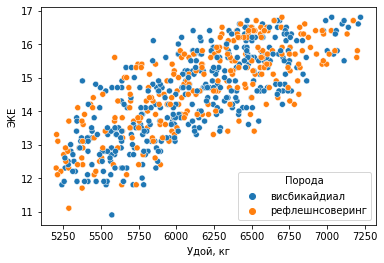

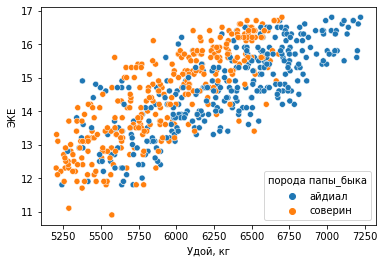

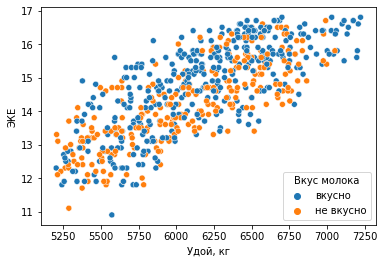

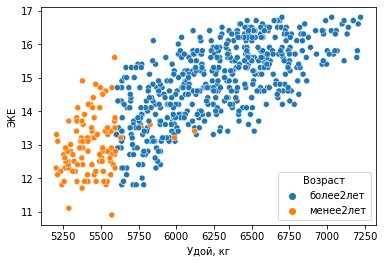

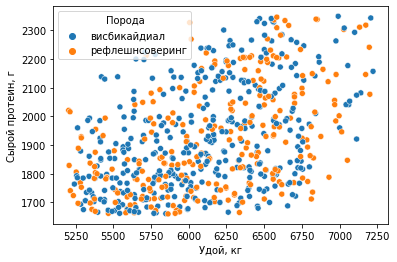

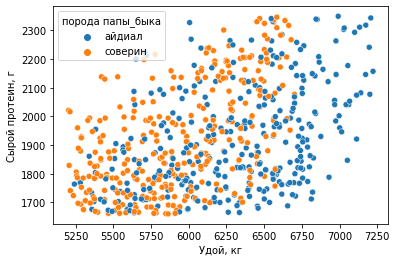

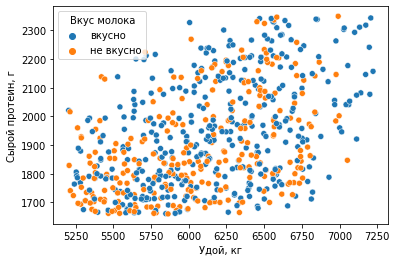

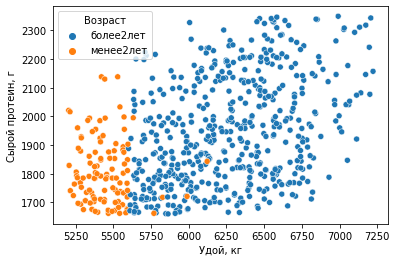

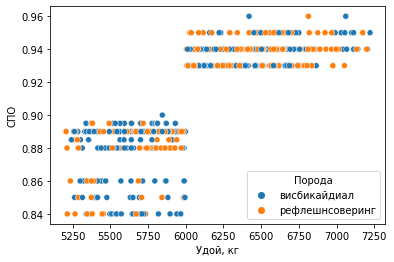

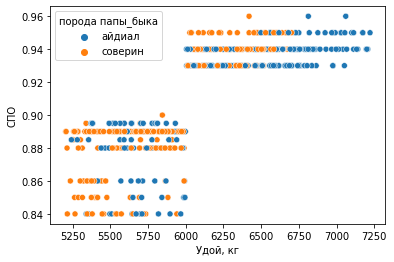

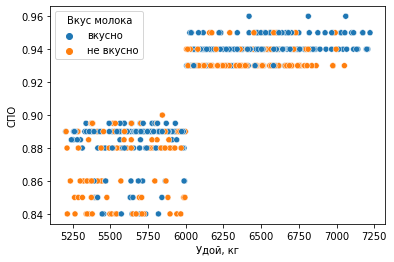

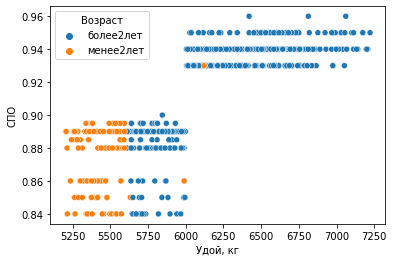

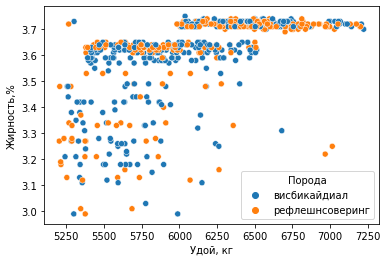

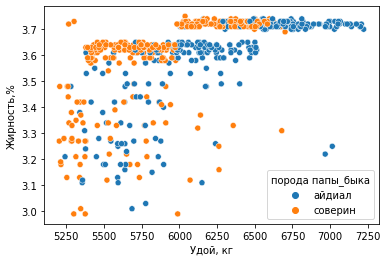

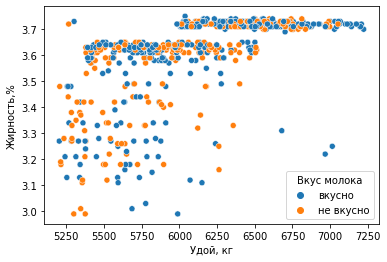

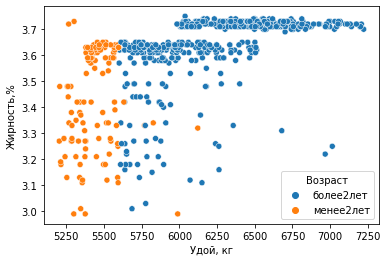

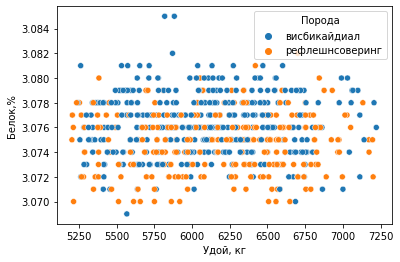

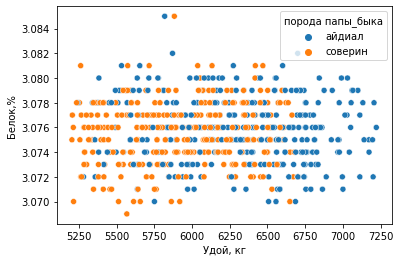

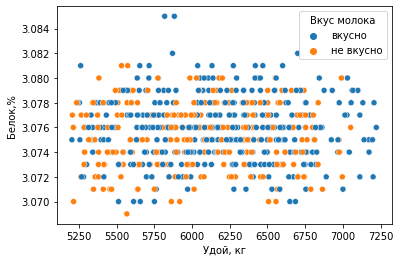

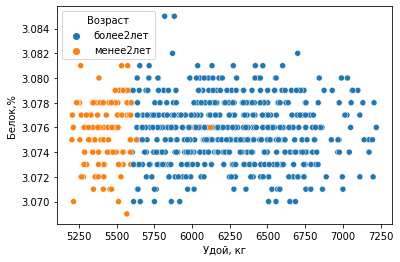

In [29]:
for y in ["ЭКЕ", "Сырой протеин, г", "СПО", "Жирность,%", "Белок,%"]:
    for hue in ["Порода", "порода папы_быка", "Вкус молока", "Возраст"]:
        sns.scatterplot(data=ferma_main, x="Удой, кг", y=y, hue = hue)
        
        plt.show()


**Вывод:**
 - у обоих пород с увеличением **ЭКЕ** увеличивается удой
 - Тип пастбища не влияет на **ЭКЕ**. Удой увеличивается с увеличением ЭКЕ
 - Коровы с папой Айдалом реагируют на увеличение **ЭКЕ** более сильно и дают больший удой
 - Вкус молока не чувствителен  к **ЭКЕ**
 - коровы в возрасте до 2х лет дают молока заметно меньше  коров старше 2х лет. Так же можно заметить, что что коровы до 2х лет не чувствительны к **ЭКЕ** в отлии от коров старше 2х лет
 - у обоих пород нет связи между количеством сырого протеина и удоя
 - у обоих типов пастбища нет сильной связи между количеством сырого протеина и удоя
 - вне зависимости от породы папы нет сильной зависимости между количеством сырого протеина и удоем
 - коровы до 2х лет не чувствительны к сыром протеину ,в отличии от коров старше 2х лет
 - чем выше **СПО** тем  больше удой. Но на коров до 2х лет увеличение **СПО** не влияет
 - по графикам видно, что жирнорсть молока можно разделить на две группы- до 3.6% и 3.7%. Так же прослеживается зависимость - чем больше жирность, тем больше удой
 - количество белка не имеет связи с количеством удоя молока
 - самая высокая корреляция между ЭКЕ-Удой 0.77, СПО-Удой 0.79
 - Мультиколлениарность не выявлена


**Для обучения модели считаю , что нужно использовать следующие признаки:**
- не учитывать характеристики молока такие как : **Белок, Жирность, Вкус молока** 
- количественные признаки: **ЭКЕ, Протеин, СПО** 
- категориальные признаки: **Порода, Тип пастбища, порода папы_быка, Возраст**

## Обучение модели линейной регрессии

### **Модель 1**

In [30]:
RANDOM_STATE = 42

X = ferma_main.drop('Удой, кг', axis=1)
y = ferma_main['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 508 to 103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   ЭКЕ               471 non-null    float64
 2   Сырой протеин, г  471 non-null    int64  
 3   СПО               471 non-null    float64
 4   Порода            471 non-null    object 
 5   Тип пастбища      471 non-null    object 
 6   порода папы_быка  471 non-null    object 
 7   Жирность,%        471 non-null    float64
 8   Белок,%           471 non-null    float64
 9   Вкус молока       471 non-null    object 
 10  Возраст           471 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 44.2+ KB


In [31]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г', 'СПО']

#категориальные значения 
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names]) 
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'Возраст_менее2лет'], dtype=object)

In [32]:
#стандартизируем количественные данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [33]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [34]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions1 = model_lr.predict(X_test)

In [35]:
r2 = r2_score(y_test, predictions1)  
r2

0.7821696944499228

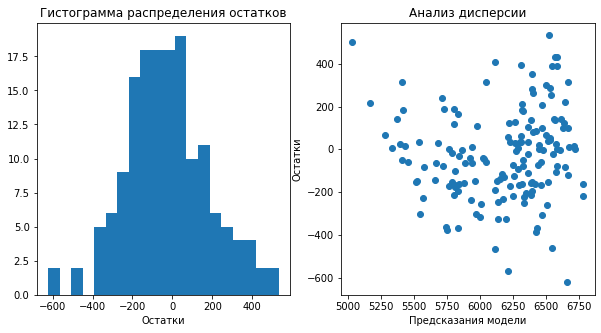

In [36]:

# проведите анализ остатков
# перед этим рассчитайте остатки
residuals = y_test - predictions1

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals,bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

- У модели коэффициент детерминации 0,78 
- Остатки имеюют нормальное распределениеи
- Разброс остатков имеет постоянный характер

### **Модель 2**

In [37]:
df = ferma_main[ferma_main.columns]


df.loc[df['СПО']<0.92, ['СПО']] = 0
df.loc[df['СПО']>=0.92, ['СПО']] = 1

df['ЭКЕ'] = df['ЭКЕ']**2

df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,201.64,1743,0.00,висбикайдиал,равнинное,айдиал,3.58,3.08,вкусно,более2лет
1,2,5529,163.84,2138,0.00,висбикайдиал,холмистое,соверин,3.54,3.08,вкусно,менее2лет
2,3,5810,196.00,1854,0.00,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более2лет
3,4,5895,153.76,2012,0.00,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более2лет
4,5,5302,163.84,1675,0.00,висбикайдиал,холмистое,соверин,3.73,3.07,вкусно,менее2лет


<AxesSubplot:xlabel='Удой, кг', ylabel='ЭКЕ'>

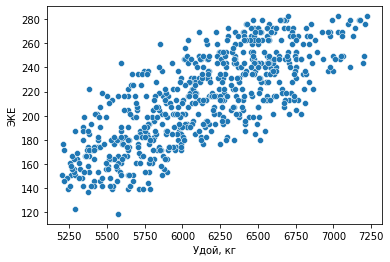

In [38]:

sns.scatterplot(data=df, x="Удой, кг", y="ЭКЕ")

In [39]:
RANDOM_STATE = 42

X = df.drop('Удой, кг', axis=1)
y = df['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 508 to 103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   ЭКЕ               471 non-null    float64
 2   Сырой протеин, г  471 non-null    int64  
 3   СПО               471 non-null    float64
 4   Порода            471 non-null    object 
 5   Тип пастбища      471 non-null    object 
 6   порода папы_быка  471 non-null    object 
 7   Жирность,%        471 non-null    float64
 8   Белок,%           471 non-null    float64
 9   Вкус молока       471 non-null    object 
 10  Возраст           471 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 44.2+ KB


In [40]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г']


#категориальные
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])


encoder_col_names = encoder.get_feature_names_out()
encoder_col_names



array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Возраст_менее2лет'],
      dtype=object)

In [41]:
#количественные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [42]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [43]:

# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions2 = model_lr.predict(X_test)

In [44]:
r2 = r2_score(y_test, predictions2)  
r2

0.8176032052894349

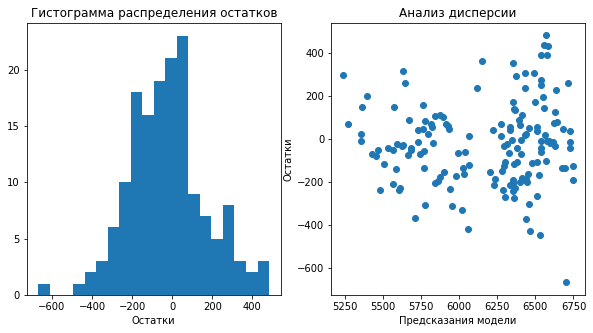

In [45]:
# проведите анализ остатков
# перед этим рассчитайте остатки2
residuals = y_test - predictions2
2
# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals,bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions2, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод**
- R2 увеличился 
- Распределение равномерное


### **Модель 3**

In [46]:
df = ferma_main[ferma_main.columns]

df.loc[df['СПО']<0.92, ['СПО']] = 0
df.loc[df['СПО']>=0.92, ['СПО']] = 1

df['ЭКЕ'] = df['ЭКЕ']**2

df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,201.64,1743,0.00,висбикайдиал,равнинное,айдиал,3.58,3.08,вкусно,более2лет
1,2,5529,163.84,2138,0.00,висбикайдиал,холмистое,соверин,3.54,3.08,вкусно,менее2лет
2,3,5810,196.00,1854,0.00,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более2лет
3,4,5895,153.76,2012,0.00,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более2лет
4,5,5302,163.84,1675,0.00,висбикайдиал,холмистое,соверин,3.73,3.07,вкусно,менее2лет


In [47]:
len(ferma_dad)

629

In [48]:
df = df.merge(ferma_dad, how  ='inner', on = 'id')

In [49]:
len(df)

628

In [50]:
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,201.64,1743,0.00,висбикайдиал,равнинное,айдиал,3.58,3.08,вкусно,более2лет,буйный
1,2,5529,163.84,2138,0.00,висбикайдиал,холмистое,соверин,3.54,3.08,вкусно,менее2лет,соловчик
2,3,5810,196.00,1854,0.00,рефлешнсоверинг,холмистое,соверин,3.59,3.07,не вкусно,более2лет,барин
3,4,5895,153.76,2012,0.00,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,не вкусно,более2лет,буйный
4,5,5302,163.84,1675,0.00,висбикайдиал,холмистое,соверин,3.73,3.07,вкусно,менее2лет,барин


In [51]:
RANDOM_STATE = 42

X = df.drop('Удой, кг', axis=1)
y = df['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   ЭКЕ               471 non-null    float64
 2   Сырой протеин, г  471 non-null    int64  
 3   СПО               471 non-null    float64
 4   Порода            471 non-null    object 
 5   Тип пастбища      471 non-null    object 
 6   порода папы_быка  471 non-null    object 
 7   Жирность,%        471 non-null    float64
 8   Белок,%           471 non-null    float64
 9   Вкус молока       471 non-null    object 
 10  Возраст           471 non-null    object 
 11  Имя Папы          471 non-null    object 
dtypes: float64(4), int64(2), object(6)
memory usage: 47.8+ KB


In [52]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г']


#категориальные
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names




array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [53]:
#количественные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [54]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [55]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions3 = model_lr.predict(X_test)

In [56]:
r2 = r2_score(y_test, predictions3)  
r2

0.8245812139053876

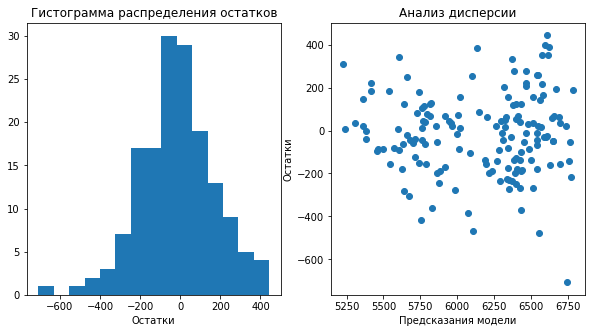

In [57]:
# проведите анализ остатков
# перед этим рассчитайте остатки
residuals = y_test - predictions3

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals,bins=15)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions3, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод**
- R2 немного увеличился
- Распределение остатков без смещения
- распределение остатков  равномерное

In [58]:
model_lr.coef_

array([  16.40680241,   36.07330388,   47.36346069,  352.90922649,
        304.00689163,  328.89680205,   20.73849575, -194.2292456 ,
        163.75501736,   52.38941751])

In [59]:
X_train

,Порода_рефлешнсоверинг,Тип пастбища_холмистое,порода папы_быка_соверин,СПО_1.0,Имя Папы_буйный,Имя Папы_геркулес,Имя Папы_соловчик,Возраст_менее2лет,ЭКЕ,"Сырой протеин, г"
0,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,1.58,1.08
1,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,-1.51,-0.20
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.08,-1.39
3,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,-0.15,0.75
4,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.10,0.83
...,...,...,...,...,...,...,...,...,...,...
466,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.67,1.57
467,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.24,-1.00
468,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.89,-0.82
469,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,-1.10,0.13


In [60]:
def metrics(a, b, c):
    mae = mean_absolute_error(b, c)
    mse = mean_squared_error(b, c)
    rmse = np.sqrt(mse)
    print(a, ', mae:',mae, ', mse:', mse, ', rmse:', rmse)

In [61]:
metrics('Модель1',y_test, predictions1)

Модель1 , mae: 164.70495937057103 , mse: 44342.61841667468 , rmse: 210.5768705643492


In [62]:
metrics('Модель2',y_test, predictions2)

Модель2 , mae: 149.57347894516988 , mse: 37129.59704046226 , rmse: 192.69041761453073


In [63]:
metrics('Модель3',y_test, predictions3)

Модель3 , mae: 146.1483537977184 , mse: 35709.11896426396 , rmse: 188.96856607452986


In [64]:
print('95% доверительный интервал =', st.norm.interval(0.95, loc=np.mean(predictions3), scale=st.sem(predictions3)))

95% доверительный интервал = (6092.752149892067, 6221.282655226105)


**Вывод:**

- Модель лучшего всего подходит для отбора
- Модель ошибается на 188.9 кг

In [65]:
cow_buy['ЭКЕ'] = df['ЭКЕ'].mean()*1.05
cow_buy['СПО'] = df['СПО'].mean()*1.05
cow_buy['Сырой протеин, г'] = ferma_main['Сырой протеин, г'].mean()*1.05

In [66]:
cow_buy.loc[df['СПО']<0.92, ['СПО']] = 0
cow_buy.loc[df['СПО']>=0.92, ['СПО']] = 1

In [67]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ,СПО,"Сырой протеин, г"
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95"
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.08,менее2лет,224.03,0.00,"2,019.95"
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет,224.03,0.00,"2,019.95"
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более2лет,224.03,0.00,"2,019.95"
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более2лет,224.03,0.00,"2,019.95"


In [68]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г']


#категориальные

cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])


encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [69]:
#количественные
cow_buy_scaled = scaler.transform(cow_buy[num_col_names])

In [70]:
#соединяем
X_test_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [71]:
# обучение модели и получение предсказаний на тестовых данных

predictions_cow_buy_new_scaled = model_lr.predict(X_test)
predictions_cow_buy_new_scaled

array([6202.45957456, 5994.63057536, 5901.25973174, 6193.97646656,
       6157.90316268, 6035.92728818, 6202.45957456, 6541.76904745,
       6254.16895823, 5999.74722096, 5941.66472895, 6583.06576027,
       6555.36880106, 6079.6062141 , 6254.16895823, 6546.88569305,
       5941.66472895, 6388.83651468, 6188.85982096, 6510.81238917])

In [72]:
result = cow_buy[cow_buy.columns]
result['Удой, кг'] = predictions_cow_buy_new_scaled
result

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ,СПО,"Сырой протеин, г","Удой, кг"
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95","6,202.46"
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.08,менее2лет,224.03,0.00,"2,019.95","5,994.63"
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет,224.03,0.00,"2,019.95","5,901.26"
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более2лет,224.03,0.00,"2,019.95","6,193.98"
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более2лет,224.03,0.00,"2,019.95","6,157.90"
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.05,менее2лет,224.03,0.00,"2,019.95","6,035.93"
6,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95","6,202.46"
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.08,более2лет,224.03,1.00,"2,019.95","6,541.77"
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет,224.03,1.00,"2,019.95","6,254.17"
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.08,менее2лет,224.03,0.00,"2,019.95","5,999.75"


In [73]:
len(result[result['Удой, кг']>=6000])

15

15 коров дают удой более 6000 кг

## Обучение модели логистической регрессии

In [74]:
df.loc[df['СПО']<0.92, ['СПО']] = 0
df.loc[df['СПО']>=0.92, ['СПО']] = 1


df['Вкус молока'] = df['Вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

df['Вкус молока'] = df['Вкус молока'].astype(float)


df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,201.64,1743,0.00,висбикайдиал,равнинное,айдиал,3.58,3.08,1.00,более2лет,буйный
1,2,5529,163.84,2138,0.00,висбикайдиал,холмистое,соверин,3.54,3.08,1.00,менее2лет,соловчик
2,3,5810,196.00,1854,0.00,рефлешнсоверинг,холмистое,соверин,3.59,3.07,0.00,более2лет,барин
3,4,5895,153.76,2012,0.00,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,0.00,более2лет,буйный
4,5,5302,163.84,1675,0.00,висбикайдиал,холмистое,соверин,3.73,3.07,1.00,менее2лет,барин


In [75]:
df = df.merge(ferma_dad, how  ='inner', on = ['id','Имя Папы'])

In [76]:
df.head()

,id,"Удой, кг",ЭКЕ,"Сырой протеин, г",СПО,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,201.64,1743,0.00,висбикайдиал,равнинное,айдиал,3.58,3.08,1.00,более2лет,буйный
1,2,5529,163.84,2138,0.00,висбикайдиал,холмистое,соверин,3.54,3.08,1.00,менее2лет,соловчик
2,3,5810,196.00,1854,0.00,рефлешнсоверинг,холмистое,соверин,3.59,3.07,0.00,более2лет,барин
3,4,5895,153.76,2012,0.00,рефлешнсоверинг,холмистое,айдиал,3.40,3.08,0.00,более2лет,буйный
4,5,5302,163.84,1675,0.00,висбикайдиал,холмистое,соверин,3.73,3.07,1.00,менее2лет,барин


In [77]:
RANDOM_STATE = 42

X = df.drop('Вкус молока', axis=1)
y = df['Вкус молока']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   Удой, кг          471 non-null    int64  
 2   ЭКЕ               471 non-null    float64
 3   Сырой протеин, г  471 non-null    int64  
 4   СПО               471 non-null    float64
 5   Порода            471 non-null    object 
 6   Тип пастбища      471 non-null    object 
 7   порода папы_быка  471 non-null    object 
 8   Жирность,%        471 non-null    float64
 9   Белок,%           471 non-null    float64
 10  Возраст           471 non-null    object 
 11  Имя Папы          471 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 47.8+ KB


In [78]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г', 'Жирность,%', 'Белок,%']


#стандартизируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names


array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [79]:
#стандартизируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [80]:
#соединяем
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
X_train.head()

,Порода_рефлешнсоверинг,Тип пастбища_холмистое,порода папы_быка_соверин,СПО_1.0,Имя Папы_буйный,Имя Папы_геркулес,Имя Папы_соловчик,Возраст_менее2лет,ЭКЕ,"Сырой протеин, г","Жирность,%","Белок,%"
0,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,1.58,1.08,0.56,-0.68
1,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,-1.51,-0.20,-1.60,-1.45
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.08,-1.39,-2.56,1.25
3,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,-0.15,0.75,0.08,1.25
4,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-1.10,0.83,0.20,0.09


In [81]:
# обучение модели и получение предсказаний на тестовых данных
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [82]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)


print('accuracy: ',round(acc ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

accuracy:  0.631
recall:  0.619
precision:  0.886


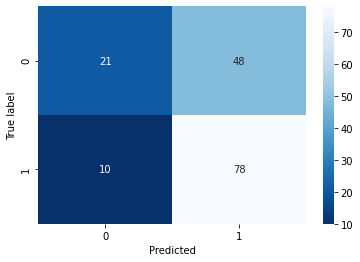

In [83]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 


- Нам важно, чтобы молоко было вкусным, поэтому наиболее выжными  надо смчитать ошибки первого рода
- precision = 88%
- В 12% модель считает ошибочно, что молоко является вкусным

In [84]:
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head())

     y_valid  y_proba
85      1.00     0.86
51      1.00     0.84
66      1.00     0.84
110     1.00     0.84
8       1.00     0.82


In [85]:
thresholds = [round(i,2) for i in np.linspace(0.55,0.85,num = 20,endpoint=False)]
print(thresholds) 

[0.55, 0.57, 0.58, 0.6, 0.61, 0.62, 0.64, 0.66, 0.67, 0.68, 0.7, 0.72, 0.73, 0.74, 0.76, 0.78, 0.79, 0.8, 0.82, 0.84]


In [86]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x > i else 0 )

# выведем 5 случайных строк
print(data.sample(5))

    y_valid  y_proba  y_pred_0.55  y_pred_0.57  y_pred_0.58  y_pred_0.6  \
58     1.00     0.68            1            1            1           1   
62     1.00     0.62            1            1            1           1   
49     0.00     0.44            0            0            0           0   
36     1.00     0.55            1            0            0           0   
45     1.00     0.65            1            1            1           1   

    y_pred_0.61  y_pred_0.62  y_pred_0.64  y_pred_0.66  ...  y_pred_0.7  \
58            1            1            1            1  ...           0   
62            1            1            0            0  ...           0   
49            0            0            0            0  ...           0   
36            0            0            0            0  ...           0   
45            1            1            1            0  ...           0   

    y_pred_0.72  y_pred_0.73  y_pred_0.74  y_pred_0.76  y_pred_0.78  \
58            0            

In [87]:
porog = []
porog = pd.DataFrame(columns=['Порог', 'Precision'])

rw = 0
for i in data.columns[2:]:
    precision = precision_score(data['y_valid'],data[i])
    porog.loc[rw] = [i, precision]
    rw = rw+1
porog

,Порог,Precision
0,y_pred_0.55,0.64
1,y_pred_0.57,0.67
2,y_pred_0.58,0.68
3,y_pred_0.6,0.72
4,y_pred_0.61,0.76
5,y_pred_0.62,0.77
6,y_pred_0.64,0.77
7,y_pred_0.66,0.78
8,y_pred_0.67,0.79
9,y_pred_0.68,0.82


 - порог  при котором минимизируется  ошибка первого рода составляет  0,8

**Спрогнозируем вкус молока у покупаемых коров**

In [88]:
cow_buy['ЭКЕ'] = df['ЭКЕ'].mean()*1.05
cow_buy['СПО'] = df['СПО'].mean()*1.05
cow_buy['Сырой протеин, г'] = df['Сырой протеин, г'].mean()*1.05

cow_buy.loc[df['СПО']<0.92, ['СПО']] = 0
cow_buy.loc[df['СПО']>=0.92, ['СПО']] = 1

In [89]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ,СПО,"Сырой протеин, г"
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95"
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.08,менее2лет,224.03,0.00,"2,019.95"
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет,224.03,0.00,"2,019.95"
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более2лет,224.03,0.00,"2,019.95"
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более2лет,224.03,0.00,"2,019.95"


In [90]:
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'СПО', 'Имя Папы', 'Возраст']
num_col_names = ['ЭКЕ', 'Сырой протеин, г', 'Жирность,%', 'Белок,%']


#категориальные

cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])


encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['Порода_рефлешнсоверинг', 'Тип пастбища_холмистое',
       'порода папы_быка_соверин', 'СПО_1.0', 'Имя Папы_буйный',
       'Имя Папы_геркулес', 'Имя Папы_соловчик', 'Возраст_менее2лет'],
      dtype=object)

In [91]:
#количественные
cow_buy_scaled = scaler.transform(cow_buy[num_col_names])

In [92]:
#соединяем
X_test_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [93]:
# получение предсказаний

predictions_cow_buy_scaled = clf.predict_proba(X_test)[:,1] > 0.8
predictions_cow_buy_scaled  = ['Вкусное' if x==True else 'Не вкусное' for x in predictions_cow_buy_scaled]
predictions_cow_buy_scaled

['Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное']

In [94]:
result['Вкус'] = predictions_cow_buy_scaled
result

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ,СПО,"Сырой протеин, г","Удой, кг",Вкус
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95","6,202.46",Вкусное
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.08,менее2лет,224.03,0.00,"2,019.95","5,994.63",Не вкусное
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет,224.03,0.00,"2,019.95","5,901.26",Не вкусное
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.06,более2лет,224.03,0.00,"2,019.95","6,193.98",Не вкусное
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.07,более2лет,224.03,0.00,"2,019.95","6,157.90",Не вкусное
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.05,менее2лет,224.03,0.00,"2,019.95","6,035.93",Не вкусное
6,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95","6,202.46",Вкусное
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.08,более2лет,224.03,1.00,"2,019.95","6,541.77",Не вкусное
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.07,более2лет,224.03,1.00,"2,019.95","6,254.17",Не вкусное
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.08,менее2лет,224.03,0.00,"2,019.95","5,999.75",Вкусное


In [95]:
vkus = len(result[result['Вкус'] == 'Вкусное'])

In [96]:
print('Количество буренок удовлетворяющих целевому признаку Вкус молока составляет:', vkus)

Количество буренок удовлетворяющих целевому признаку Вкус молока составляет: 3


In [97]:
result[(result['Удой, кг'] >= 6000)&(result['Вкус'] != 'Не вкусное')]

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Жирность,%","Белок,%",Возраст,ЭКЕ,СПО,"Сырой протеин, г","Удой, кг",Вкус
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95","6,202.46",Вкусное
6,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.08,более2лет,224.03,0.00,"2,019.95","6,202.46",Вкусное


Только две буренки из стада удовлетворяют всем требованиям фермера

## Итоговые выводы

- Мы провели загрузку данных
- Провели предобработку данных
- Удалили дубликаты
- привели все данные и столбцы к единым значениям 
- построили три модели и выбрали самую лучшую для прогноза удоя м олока у покупаемых коров 
- построили логистическую модель для предсказания вуса молока


**После предсказания удоя и вкуса молока можно сделать вывод, что только две коровы  удовлетворяют всем требованиям фермера**